# Packages, Data, Functions

In [1]:
# Import packages
import numpy as np
import skimage.io as skio
import skimage.morphology as skm
from skimage import feature
from skimage.color import rgb2gray
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.cluster import KMeans
from sklearn.utils.random import sample_without_replacement
from scipy.ndimage import gaussian_filter
from scipy.ndimage import gaussian_laplace
from scipy.ndimage import maximum_filter
from scipy.ndimage import minimum_filter
from scipy.ndimage import median_filter

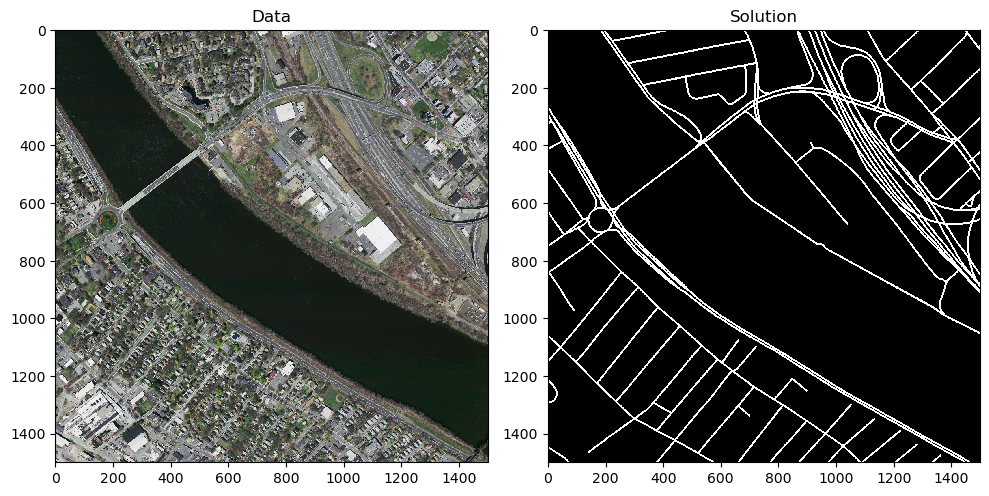

In [2]:
# Read the data
rgb = skio.imread("../../data/MA_roads/tiff/train/10828735_15.tiff")
ans = skio.imread("../../data/MA_roads/tiff/train_labels/10828735_15.tif") > 0

rgb_test = skio.imread("../../data/MA_roads/tiff/train/21929005_15.tiff")
ans_test = skio.imread("../../data/MA_roads/tiff/train_labels/21929005_15.tif") > 0

# Display training data and correct output
fig, ax = plt.subplots(1, 2, figsize = (10, 6))
skio.imshow(rgb, ax = ax[0])
ax[0].set_title("Data")
skio.imshow(ans, ax = ax[1])
ax[1].set_title("Solution");

In [3]:
# Function to print several accuracy metrics
def accuracy_metrics(y_true, y_pred):
    # Create confusion matrix
    C = confusion_matrix(y_true, y_pred)

    # Overall accuracy rate
    acc = (C[0,0] + C[1,1])/C.sum()

    # True positive rate
    tpr = (C[0,0])/(C[0,0] + C[0,1])
    
    # True negative rate
    tnr = (C[1,1])/(C[1,0] + C[1,1])

    # Print results
    print("Confusion matrix:\n", C)
    print("Overall accuracy:", np.round(acc, 3), "\nTrue positive rate (not road):", np.round(tpr, 3), "\nTrue negative rate (roads)", np.round(tnr, 3)) 

# Create Training and Testing Subsets

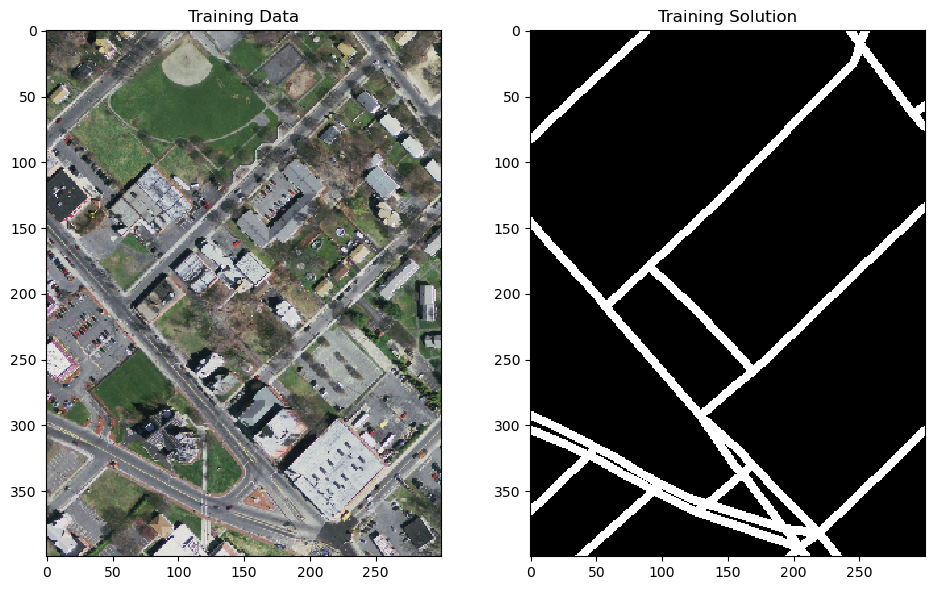

In [4]:
# Create training subset of data
# It takes too much computing power to run the model on the whole image on our own machines
small_rgb = rgb[0:400, 1200:, :]
small_ans = ans[0:400, 1200:]
# small_rgb = rgb
# small_ans = ans

fig, ax = plt.subplots(1, 2, figsize = (10, 6))
skio.imshow(small_rgb, ax = ax[0])
ax[0].set_title("Training Data")
skio.imshow(small_ans, ax = ax[1])
ax[1].set_title("Training Solution");

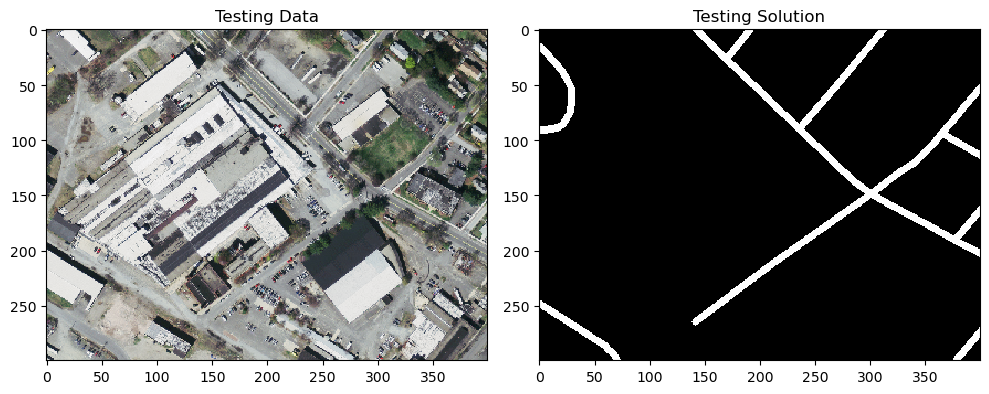

In [5]:
# Create testing subset of data
# It takes too much computing power to run the model on the whole image on our own machines
small_rgb_test = rgb[1200:, 0:400, :]
small_ans_test = ans[1200:, 0:400]
# small_rgb_test = rgb_test
# small_ans_test = ans_test

fig, ax = plt.subplots(1, 2, figsize = (10, 6))
skio.imshow(small_rgb_test, ax = ax[0])
ax[0].set_title("Testing Data")
skio.imshow(small_ans_test, ax = ax[1])
ax[1].set_title("Testing Solution");

# Random Forest Model: RGB
## Train model

In [7]:
# Flatten images
train_small_rgb = small_rgb.reshape(small_rgb.shape[0]*small_rgb.shape[1], 3)
y_train = small_ans.reshape(small_ans.shape[0]*small_ans.shape[1])

In [8]:
# Create model
RF = RandomForestClassifier()

# Fit and output the performance of the model
model1 = RF.fit(train_small_rgb, y_train)

In [9]:
# Predictions on training data
model1_pred = model1.predict(train_small_rgb)

# Confusion matrix
accuracy_metrics(y_train, model1_pred)

Confusion matrix:
 [[105440   1537]
 [  4037   8986]]
Overall accuracy: 0.954 
True positive rate (not road): 0.986 
True negative rate (roads) 0.69


While we have a really good overall accuracy rate, we are correctly predicting only 68.7% of the road pixels.

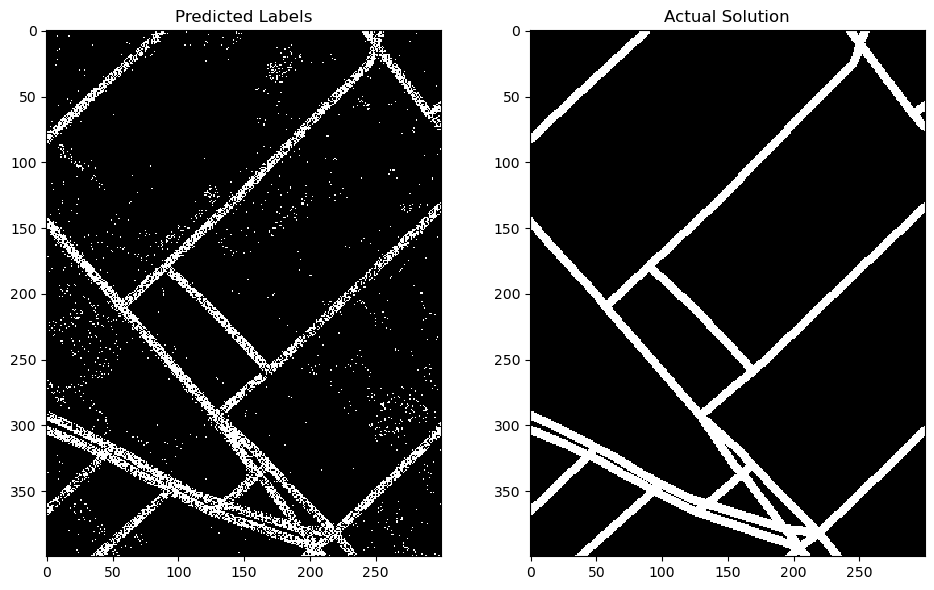

In [10]:
# Convert predictions to image
train_preds = model1_pred.reshape(small_ans.shape[0], small_ans.shape[1])

# Create figure
fig, ax = plt.subplots(1, 2, figsize = (10, 6))

skio.imshow(train_preds, ax = ax[0])
ax[0].set_title("Predicted Labels")

skio.imshow(small_ans, ax = ax[1])
ax[1].set_title("Actual Solution");

Visually, our solution looks alright, but it obviously has room for improvement.
Let's see what our results look like on the testing data.

## Test model

In [11]:
# Flatten images
test_small_rgb = small_rgb_test.reshape(small_rgb_test.shape[0]*small_rgb_test.shape[1], 3)
y_test = small_ans_test.reshape(small_ans_test.shape[0]*small_ans_test.shape[1])

In [12]:
# Predictions on testing data
model1_test_pred = model1.predict(test_small_rgb)

# Confusion matrix
accuracy_metrics(y_test, model1_test_pred)

Confusion matrix:
 [[108082   4815]
 [  6498    605]]
Overall accuracy: 0.906 
True positive rate (not road): 0.957 
True negative rate (roads) 0.085


While we still have a good overall accuracy rate, our predictions of roads is substantially worse.
We have only classified 8.3% of the road pixels correctly.

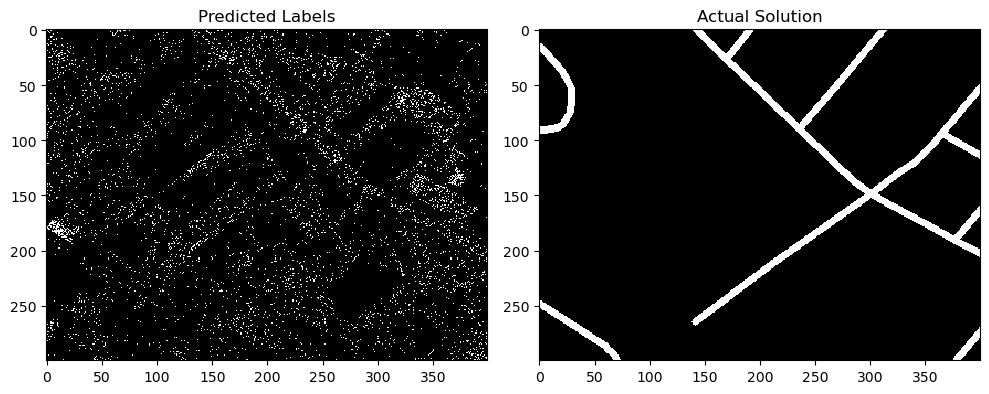

In [13]:
# Convert predictions to image
test_preds = model1_test_pred.reshape(small_ans_test.shape[0], small_ans_test.shape[1])

# Create figure
fig, ax = plt.subplots(1, 2, figsize = (10, 6))

skio.imshow(test_preds, ax = ax[0])
ax[0].set_title("Predicted Labels")

skio.imshow(small_ans_test, ax = ax[1])
ax[1].set_title("Actual Solution");

Our model did NOT generalize well! This looks terrible!

# Incorporating Additional Layers

## Train Model

In [14]:
# Create additional features

# Range of values (gray pixels will have low range)
r = small_rgb.max(axis = 2) - small_rgb.min(axis = 2)

# Canny edge detection
canny_edges_r = feature.canny(small_rgb[:,:,0], sigma=4);
canny_edges_g = feature.canny(small_rgb[:,:,1], sigma=4);
canny_edges_b = feature.canny(small_rgb[:,:,2], sigma=4);

# Gaussian blur sigma = 1
gaus_r_1 = gaussian_filter(small_rgb[:,:,0], sigma = 1)
gaus_g_1 = gaussian_filter(small_rgb[:,:,1], sigma = 1)
gaus_b_1 = gaussian_filter(small_rgb[:,:,2], sigma = 1)

# Gaussian blur sigma = 3
gaus_r_3 = gaussian_filter(small_rgb[:,:,0], sigma = 3)
gaus_g_3 = gaussian_filter(small_rgb[:,:,1], sigma = 3)
gaus_b_3 = gaussian_filter(small_rgb[:,:,2], sigma = 3)

# Gaussian blur sigma = 5
gaus_r_5 = gaussian_filter(small_rgb[:,:,0], sigma = 5)
gaus_g_5 = gaussian_filter(small_rgb[:,:,1], sigma = 5)
gaus_b_5 = gaussian_filter(small_rgb[:,:,2], sigma = 5)

# LoG blur sigma = .5
log_r_5 = gaussian_laplace(small_rgb[:,:,0], sigma = .5)
log_g_5 = gaussian_laplace(small_rgb[:,:,1], sigma = .5)
log_b_5 = gaussian_laplace(small_rgb[:,:,2], sigma = .5)

# LoG blur sigma = .6
log_r_6 = gaussian_laplace(small_rgb[:,:,0], sigma = .6)
log_g_6 = gaussian_laplace(small_rgb[:,:,1], sigma = .6)
log_b_6 = gaussian_laplace(small_rgb[:,:,2], sigma = .6)

# LoG blur sigma = .8
log_r_8 = gaussian_laplace(small_rgb[:,:,0], sigma = .8)
log_g_8 = gaussian_laplace(small_rgb[:,:,1], sigma = .8)
log_b_8 = gaussian_laplace(small_rgb[:,:,2], sigma = .8)

# Add layers to model
small_rgb_layers = np.dstack([small_rgb, r, canny_edges_r, canny_edges_g, canny_edges_b,
                             gaus_r_1, gaus_g_1, gaus_b_1, gaus_r_3, gaus_g_3, gaus_b_3,
                             gaus_r_5, gaus_g_5, gaus_b_5, log_r_5, log_g_5, log_b_5,
                             log_r_6, log_g_6, log_b_6, log_r_8, log_g_8, log_b_8])

In [15]:
# Train model

# Flatten image
train_small_rgb_layers = small_rgb_layers.reshape(small_rgb_layers.shape[0]*small_rgb_layers.shape[1], 25)

# Create model
RF = RandomForestClassifier()

# Fit and output the performance of the model
model2 = RF.fit(train_small_rgb_layers, y_train)

# Predictions on training data
model2_pred = model2.predict(train_small_rgb_layers)

# Confusion matrix
accuracy_metrics(y_train, model2_pred)

Confusion matrix:
 [[106977      0]
 [     0  13023]]
Overall accuracy: 1.0 
True positive rate (not road): 1.0 
True negative rate (roads) 1.0


Before adding the additional layers to our training data, our overall accuracy was 0.954, true positive rate (not road) was 0.986, and true negative rate (roads) was 0.687 (may change slightly in different runs).
Now we have virtually perfect results!
Let's look at an image of the output.

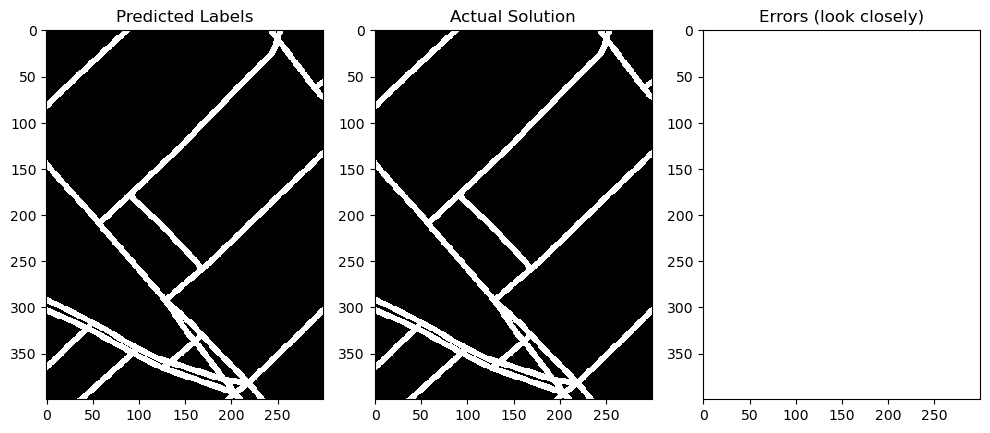

In [16]:
# Convert predictions to image
train_preds = model2_pred.reshape(small_ans.shape[0], small_ans.shape[1])

# Create figure
fig, ax = plt.subplots(1, 3, figsize = (10, 6))

skio.imshow(train_preds, ax = ax[0])
ax[0].set_title("Predicted Labels")

skio.imshow(small_ans, ax = ax[1])
ax[1].set_title("Actual Solution")

skio.imshow(train_preds==small_ans, ax = ax[2])
ax[2].set_title("Errors (look closely)");

Yep, can't even find the errors without looking closely at the difference between the two images.
Let's evaluate our results on the testing data!

## Test Model

In [17]:
# Create additional features

# Range of values (gray pixels will have low range)
rt = small_rgb_test.max(axis = 2) - small_rgb_test.min(axis = 2)

# Canny edge detection
canny_edges_rt = feature.canny(small_rgb_test[:,:,0], sigma=4);
canny_edges_gt = feature.canny(small_rgb_test[:,:,1], sigma=4);
canny_edges_bt = feature.canny(small_rgb_test[:,:,2], sigma=4);

# Gaussian blur sigma = 1
gaus_r_1t = gaussian_filter(small_rgb_test[:,:,0], sigma = 1)
gaus_g_1t = gaussian_filter(small_rgb_test[:,:,1], sigma = 1)
gaus_b_1t = gaussian_filter(small_rgb_test[:,:,2], sigma = 1)

# Gaussian blur sigma = 3
gaus_r_3t = gaussian_filter(small_rgb_test[:,:,0], sigma = 3)
gaus_g_3t = gaussian_filter(small_rgb_test[:,:,1], sigma = 3)
gaus_b_3t = gaussian_filter(small_rgb_test[:,:,2], sigma = 3)

# Gaussian blur sigma = 5
gaus_r_5t = gaussian_filter(small_rgb_test[:,:,0], sigma = 5)
gaus_g_5t = gaussian_filter(small_rgb_test[:,:,1], sigma = 5)
gaus_b_5t = gaussian_filter(small_rgb_test[:,:,2], sigma = 5)

# LoG blur sigma = .5
log_r_5t = gaussian_laplace(small_rgb_test[:,:,0], sigma = .5)
log_g_5t = gaussian_laplace(small_rgb_test[:,:,1], sigma = .5)
log_b_5t = gaussian_laplace(small_rgb_test[:,:,2], sigma = .5)

# LoG blur sigma = .6
log_r_6t = gaussian_laplace(small_rgb_test[:,:,0], sigma = .6)
log_g_6t = gaussian_laplace(small_rgb_test[:,:,1], sigma = .6)
log_b_6t = gaussian_laplace(small_rgb_test[:,:,2], sigma = .6)

# LoG blur sigma = .8
log_r_8t = gaussian_laplace(small_rgb_test[:,:,0], sigma = .8)
log_g_8t = gaussian_laplace(small_rgb_test[:,:,1], sigma = .8)
log_b_8t = gaussian_laplace(small_rgb_test[:,:,2], sigma = .8)

# Add layers to model
small_rgb_test_layers = np.dstack([small_rgb_test, rt, canny_edges_rt, canny_edges_gt, canny_edges_bt,
                             gaus_r_1t, gaus_g_1t, gaus_b_1t, gaus_r_3t, gaus_g_3t, gaus_b_3t,
                             gaus_r_5t, gaus_g_5t, gaus_b_5t, log_r_5t, log_g_5t, log_b_5t,
                             log_r_6t, log_g_6t, log_b_6t, log_r_8t, log_g_8t, log_b_8t])

In [18]:
# Flatten image
test_small_rgb_layers = small_rgb_test_layers.reshape(small_rgb_test_layers.shape[0]*small_rgb_test_layers.shape[1], 25)

# Predictions on testing data
model2_test_pred = model2.predict(test_small_rgb_layers)

# Confusion matrix
accuracy_metrics(y_test, model2_test_pred)

Confusion matrix:
 [[110960   1937]
 [  6768    335]]
Overall accuracy: 0.927 
True positive rate (not road): 0.983 
True negative rate (roads) 0.047


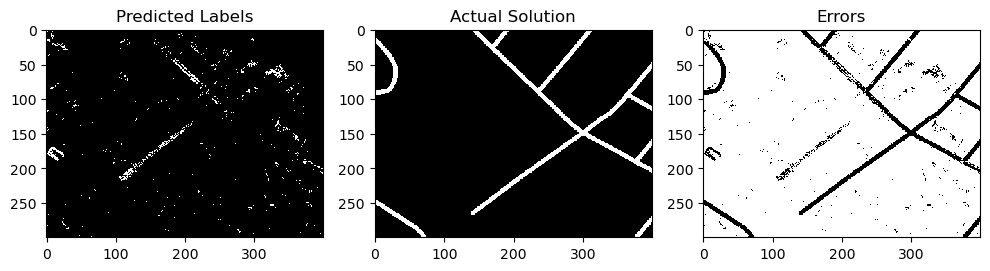

In [19]:
# Convert predictions to image
test_preds = model2_test_pred.reshape(small_ans_test.shape[0], small_ans_test.shape[1])

# Create figure
fig, ax = plt.subplots(1, 3, figsize = (10, 6))

skio.imshow(test_preds, ax = ax[0], cmap = "gray")
ax[0].set_title("Predicted Labels")

skio.imshow(small_ans_test, ax = ax[1])
ax[1].set_title("Actual Solution")

skio.imshow(test_preds==small_ans_test, ax = ax[2])
ax[2].set_title("Errors");

Adding these filters to our model had negligible impact on our results.
It improved the accuracy from 0.906 to 0.927, the true positive rate (not road) from 0.958 to 0.983, but decreased the true negative rate (roads) from 0.086 to 0.046, which is what we were really hoping to improve.
It seems that incorporating these features in our training data led to severe overfitting!

# Adjusting for Overfitting

We have fed a substantial amount of data, which ought to contain some useful information regarding roads, to our model.
However, .....

FINISH EXPLAINING MOTIVE!

## Train RGB Model

In [124]:
# Flatten training images
train_rgb = rgb.reshape(rgb.shape[0]*rgb.shape[1], 3)
y_train = ans.reshape(ans.shape[0]*ans.shape[1])

# Subset training data by label
y_train_true = y_train[y_train]
y_train_false = y_train[~y_train]
train_rgb_true = train_rgb[y_train]
train_rgb_false = train_rgb[~y_train]

# Sample indices of each label
true_indices = sample_without_replacement(y_train_true.shape[0], 10000)
false_indices = sample_without_replacement(y_train_false.shape[0], 10000)

# Create modified training data
y_train_mod = np.concatenate([y_train_true[true_indices[:5000]], y_train_false[false_indices[:5000]]])
train_rgb_mod = np.concatenate([train_rgb_true[true_indices[:5000]], train_rgb_false[false_indices[:5000]]])

# Create modified testing data
y_test_mod = np.concatenate([y_train_true[true_indices[5000:]], y_train_false[false_indices[5000:]]])
test_rgb_mod = np.concatenate([train_rgb_true[true_indices[5000:]], train_rgb_false[false_indices[5000:]]])

In [125]:
# Create model
RF = RandomForestClassifier()

# Fit and output the performance of the model
model3 = RF.fit(train_rgb_mod, y_train_mod)

# Predictions on training data
model3_pred = model3.predict(train_rgb_mod)

# Confusion matrix
accuracy_metrics(y_train_mod, model3_pred)

Confusion matrix:
 [[4927   73]
 [  41 4959]]
Overall accuracy: 0.989 
True positive rate (not road): 0.985 
True negative rate (roads) 0.992


EXPLAIN THE RESULTS!

## Test RGB Model

In [126]:
# Predictions on testing data
model3_test_pred = model3.predict(test_rgb_mod)

# Confusion matrix
accuracy_metrics(y_test_mod, model3_test_pred)

Confusion matrix:
 [[3737 1263]
 [1183 3817]]
Overall accuracy: 0.755 
True positive rate (not road): 0.747 
True negative rate (roads) 0.763


DISCUSS RESULTS

## Train Additional Layers Model

In [137]:
# Create additional features

# Range of values (gray pixels will have low range)
r_2 = rgb.max(axis = 2) - rgb.min(axis = 2)

# Canny edge detection
canny_edges_r_2 = feature.canny(rgb[:,:,0], sigma=4);
canny_edges_g_2 = feature.canny(rgb[:,:,1], sigma=4);
canny_edges_b_2 = feature.canny(rgb[:,:,2], sigma=4);

# Gaussian blur sigma = 1
gaus_r_1_2 = gaussian_filter(rgb[:,:,0], sigma = 1)
gaus_g_1_2 = gaussian_filter(rgb[:,:,1], sigma = 1)
gaus_b_1_2 = gaussian_filter(rgb[:,:,2], sigma = 1)

# Gaussian blur sigma = 3
gaus_r_3_2 = gaussian_filter(rgb[:,:,0], sigma = 3)
gaus_g_3_2 = gaussian_filter(rgb[:,:,1], sigma = 3)
gaus_b_3_2 = gaussian_filter(rgb[:,:,2], sigma = 3)

# Gaussian blur sigma = 5
gaus_r_5_2 = gaussian_filter(rgb[:,:,0], sigma = 5)
gaus_g_5_2 = gaussian_filter(rgb[:,:,1], sigma = 5)
gaus_b_5_2 = gaussian_filter(rgb[:,:,2], sigma = 5)

# LoG blur sigma = .5
log_r_5_2 = gaussian_laplace(rgb[:,:,0], sigma = .5)
log_g_5_2 = gaussian_laplace(rgb[:,:,1], sigma = .5)
log_b_5_2 = gaussian_laplace(rgb[:,:,2], sigma = .5)

# LoG blur sigma = .6
log_r_6_2 = gaussian_laplace(rgb[:,:,0], sigma = .6)
log_g_6_2 = gaussian_laplace(rgb[:,:,1], sigma = .6)
log_b_6_2 = gaussian_laplace(rgb[:,:,2], sigma = .6)

# LoG blur sigma = .8
log_r_8_2 = gaussian_laplace(rgb[:,:,0], sigma = .8)
log_g_8_2 = gaussian_laplace(rgb[:,:,1], sigma = .8)
log_b_8_2 = gaussian_laplace(rgb[:,:,2], sigma = .8)

# Add layers to model
train_rgb_mod_layers = np.dstack([rgb, r_2, canny_edges_r_2, canny_edges_g_2, canny_edges_b_2,
                             gaus_r_1_2, gaus_g_1_2, gaus_b_1_2, gaus_r_3_2, gaus_g_3_2, gaus_b_3_2,
                             gaus_r_5_2, gaus_g_5_2, gaus_b_5_2, log_r_5_2, log_g_5_2, log_b_5_2,
                             log_r_6_2, log_g_6_2, log_b_6_2, log_r_8_2, log_g_8_2, log_b_8_2])

# Flatten training image with extra layers
train_rgb_2 = train_rgb_mod_layers.reshape(train_rgb_mod_layers.shape[0]*train_rgb_mod_layers.shape[1], 25)

# Subset training data by label
train_rgb_true_2 = train_rgb_2[y_train]
train_rgb_false_2 = train_rgb_2[~y_train]

# Create modified training data
train_rgb_mod_2 = np.concatenate([train_rgb_true_2[true_indices[:5000]], train_rgb_false_2[false_indices[:5000]]])

# Create modified testing data
test_rgb_mod_2 = np.concatenate([train_rgb_true_2[true_indices[5000:]], train_rgb_false_2[false_indices[5000:]]])

In [144]:
# Create model
RF = RandomForestClassifier()

# Fit and output the performance of the model
model4 = RF.fit(test_rgb_mod_2, y_train_mod)

# Predictions on training data
model4_pred = model4.predict(test_rgb_mod_2)

# Confusion matrix
accuracy_metrics(y_train_mod, model4_pred)

Confusion matrix:
 [[5000    0]
 [   0 5000]]
Overall accuracy: 1.0 
True positive rate (not road): 1.0 
True negative rate (roads) 1.0


Talk about results!

## Test Additional Layers Model

In [145]:
# Predictions on testing data
model4_test_pred = model4.predict(test_rgb_mod_2)

# Confusion matrix
accuracy_metrics(y_test_mod, model4_test_pred)

Confusion matrix:
 [[5000    0]
 [   0 5000]]
Overall accuracy: 1.0 
True positive rate (not road): 1.0 
True negative rate (roads) 1.0


It appears that our classification worked perfectly!
While our training and testing data contained none of the same pixels, they were both drawn from the same image, so it is possible that they were overtrained to our particular image of choice.
Let's now check whether this generalizes to other images by testing on an entire image.

## Test Additional Layers Model on New Image

In [154]:
# Create additional features

# Range of values (gray pixels will have low range)
r_3 = rgb_test.max(axis = 2) - rgb_test.min(axis = 2)

# Canny edge detection
canny_edges_r_3 = feature.canny(rgb_test[:,:,0], sigma=4);
canny_edges_g_3 = feature.canny(rgb_test[:,:,1], sigma=4);
canny_edges_b_3 = feature.canny(rgb_test[:,:,2], sigma=4);

# Gaussian blur sigma = 1
gaus_r_1_3 = gaussian_filter(rgb_test[:,:,0], sigma = 1)
gaus_g_1_3 = gaussian_filter(rgb_test[:,:,1], sigma = 1)
gaus_b_1_3 = gaussian_filter(rgb_test[:,:,2], sigma = 1)

# Gaussian blur sigma = 3
gaus_r_3_3 = gaussian_filter(rgb_test[:,:,0], sigma = 3)
gaus_g_3_3 = gaussian_filter(rgb_test[:,:,1], sigma = 3)
gaus_b_3_3 = gaussian_filter(rgb_test[:,:,2], sigma = 3)

# Gaussian blur sigma = 5
gaus_r_5_3 = gaussian_filter(rgb_test[:,:,0], sigma = 5)
gaus_g_5_3 = gaussian_filter(rgb_test[:,:,1], sigma = 5)
gaus_b_5_3 = gaussian_filter(rgb_test[:,:,2], sigma = 5)

# LoG blur sigma = .5
log_r_5_3 = gaussian_laplace(rgb_test[:,:,0], sigma = .5)
log_g_5_3 = gaussian_laplace(rgb_test[:,:,1], sigma = .5)
log_b_5_3 = gaussian_laplace(rgb_test[:,:,2], sigma = .5)

# LoG blur sigma = .6
log_r_6_3 = gaussian_laplace(rgb_test[:,:,0], sigma = .6)
log_g_6_3 = gaussian_laplace(rgb_test[:,:,1], sigma = .6)
log_b_6_3 = gaussian_laplace(rgb_test[:,:,2], sigma = .6)

# LoG blur sigma = .8
log_r_8_3 = gaussian_laplace(rgb_test[:,:,0], sigma = .8)
log_g_8_3 = gaussian_laplace(rgb_test[:,:,1], sigma = .8)
log_b_8_3 = gaussian_laplace(rgb_test[:,:,2], sigma = .8)

# Add layers to model
test_rgb_layers_3 = np.dstack([rgb_test, r_3, canny_edges_r_3, canny_edges_g_3, canny_edges_b_3,
                             gaus_r_1_3, gaus_g_1_3, gaus_b_1_3, gaus_r_3_3, gaus_g_3_3, gaus_b_3_3,
                             gaus_r_5_3, gaus_g_5_3, gaus_b_5_3, log_r_5_3, log_g_5_3, log_b_5_3,
                             log_r_6_3, log_g_6_3, log_b_6_3, log_r_8_3, log_g_8_3, log_b_8_3])

# Flatten testing images
test_rgb_3 = test_rgb_layers_3.reshape(test_rgb_layers_3.shape[0]*test_rgb_layers_3.shape[1], 25)
y_test = ans_test.reshape(ans_test.shape[0]*ans_test.shape[1])

In [155]:
# Predictions on testing data
model4_test_pred_2 = model4.predict(test_rgb_3)

# Confusion matrix
accuracy_metrics(y_test, model4_test_pred_2)

Confusion matrix:
 [[1844761  264974]
 [  45466   94799]]
Overall accuracy: 0.862 
True positive rate (not road): 0.874 
True negative rate (roads) 0.676


Our model did not perform nearly as well when we tested it on an entirely different image, as the overall accuracy, true positive rate, and true negative rate are all now less than one.
However, with an accuracy rate of 86.2% and accurate road predictions of 67.6%, the model is substantially better than both our prior models and random chance.
Perhaps if we train our model on data from multiple images, our performance would be even higher.

Since we are now working with a complete image, we can once again inspect a full image illustrating our predictions versus the truth.

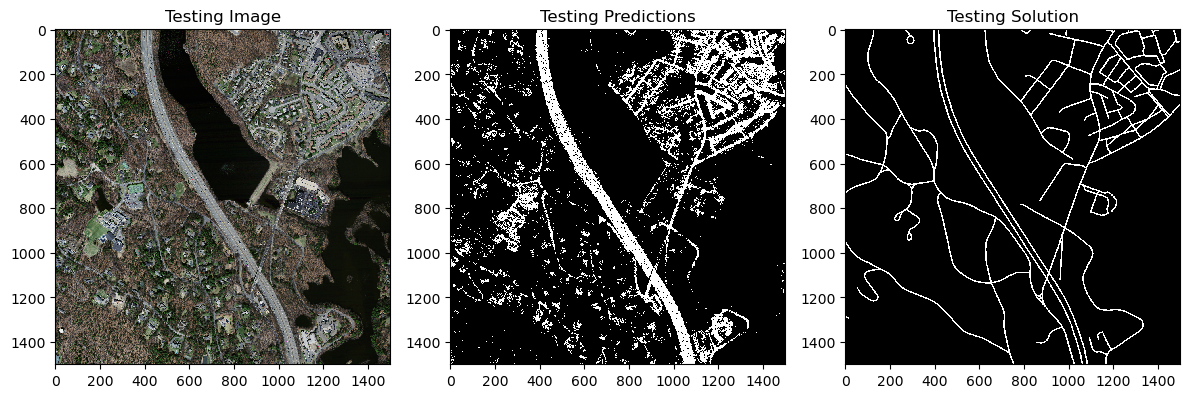

In [156]:
# Convert predictions to image
test_preds = model4_test_pred_2.reshape(test_rgb_layers_3.shape[0], test_rgb_layers_3.shape[1])

# Create figure
fig, ax = plt.subplots(1, 3, figsize = (12, 6))
skio.imshow(rgb_test, ax = ax[0])
ax[0].set_title("Testing Image")
skio.imshow(test_preds, ax = ax[1])
ax[1].set_title("Testing Predictions")
skio.imshow(ans_test, ax = ax[2])
ax[2].set_title("Testing Solution");

# Future work...?

- try min, max, median filters?

In [ ]:
# train_gray = rgb2gray(small_rgb)
# skio.imshow(train_gray)

# disk = skm.disk(3)
# disk4 = skm.disk(4)

# img_med = median_filter(train_gray, footprint = disk4)
# img_max = maximum_filter(img_med, footprint = disk)

# fig, ax = plt.subplots(1, 3, figsize = (12, 6))
# skio.imshow(img_max, ax = ax[0])
# skio.imshow(img_med, ax = ax[1])